<a href="https://colab.research.google.com/github/SaswatD27/SyrDataSuppression/blob/main/AdultSyr2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import pipeline_dp as pdp
import math

In [140]:
df=pd.read_csv("adult.csv")

In [141]:
pd.read_csv("adult.csv")

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


##Target Attributes
* Age
* Income
* Hours per week

 (Maybe gender)

In [142]:
mar_df=pd.DataFrame()

In [143]:
max_age=df["age"].max()

In [144]:
for i in range(int(max_age/10)):
  df2=df[(df['age']<=(i+1)*10) & (df['age']>i*10) & (df['income']==">50K") & (df['hours-per-week'] >30)]
  #print(df2.head())
  mar_df=mar_df.append(df2, ignore_index=True)
  #print(mar_df.head())

In [145]:
mar_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,20,Private,325033,12th,8,Never-married,Other-service,Own-child,Black,Male,0,0,35,United-States,>50K
1,19,Private,323605,7th-8th,4,Never-married,Other-service,Not-in-family,White,Male,0,0,60,United-States,>50K
2,19,?,200790,12th,8,Married-civ-spouse,?,Other-relative,White,Female,15024,0,40,United-States,>50K
3,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
4,28,Private,242832,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,36,United-States,>50K


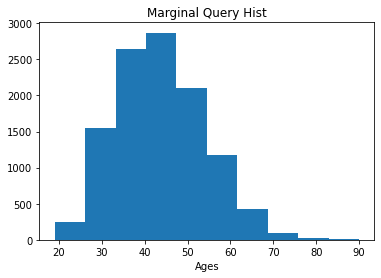

In [146]:
plt.hist(mar_df['age'])
plt.title('Marginal Query Hist')
plt.xlabel('Ages')
plt.show()

In [147]:
counts=[]
for i in range(int(max_age/10)):
  add_df=mar_df[(mar_df['age']>i*10) & (mar_df['age']<=(i+1)*10)]['age']
  counts.append(add_df.count())

In [148]:
print(counts)
ages=[str(i*10)+" to "+str((i+1)*10) for i in range(int(max_age/10))]
print(ages)

[0, 3, 955, 3487, 3860, 2170, 591, 75, 20]
['0 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80', '80 to 90']


In [149]:
#Age sum approximation from bins
est_bin_age_sum=list(map(lambda a: ((a*10)+5)*counts[a], range(len(counts))))
print(sum(est_bin_age_sum))
#Actual age sum
act_age_sum=mar_df['age'].sum()
print(act_age_sum)
#Minorities' age sum (0<age<=20 and age>80)
min_age_sum=mar_df[(mar_df['age']<=20) | (mar_df['age']>80)]['age'].sum()
print(min_age_sum)
#Two types of error analyses shall be considered: one based purely on counts, 
#another on estimated age sums (the latter is because otherwise, 
#we shall not be able to calculate the error for k anonymity using counts purely.)

484755
490472
1804


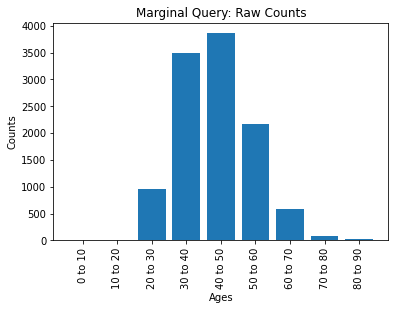

In [166]:
plt.bar(ages,counts)
plt.xticks(rotation=90)
plt.title('Marginal Query: Raw Counts')
plt.xlabel('Ages')
plt.ylabel('Counts')
plt.show()
#Better representation

## Anonymisation!! Reallocation first
* Threshold = 40

So let's say that we have $k$-anonymity with $1\leq k\leq 40$, then the following behaviour should be the same in this context.

In [151]:
'''
counts_2=counts[:]
counts_2.append(-1)
anon_counts=counts_2[:]
i=0
while anon_counts[i]!=-1:
  if anon_counts[i]<40 and anon_counts[i+1]!=-1:
    anon_counts[i+1]=anon_counts[i]+anon_counts[i+1]
    counts_2[i+1]=counts_2[i]+counts_2[i+1]
    del anon_counts[i]
    del counts_2[i]
    i=0
  elif anon_counts[i]<40 and anon_counts[i+1]==-1:
    anon_counts[i-1]=anon_counts[i-1]+anon_counts[i]
    del anon_counts[i]
    i=0
'''

'\ncounts_2=counts[:]\ncounts_2.append(-1)\nanon_counts=counts_2[:]\ni=0\nwhile anon_counts[i]!=-1:\n  if anon_counts[i]<40 and anon_counts[i+1]!=-1:\n    anon_counts[i+1]=anon_counts[i]+anon_counts[i+1]\n    counts_2[i+1]=counts_2[i]+counts_2[i+1]\n    del anon_counts[i]\n    del counts_2[i]\n    i=0\n  elif anon_counts[i]<40 and anon_counts[i+1]==-1:\n    anon_counts[i-1]=anon_counts[i-1]+anon_counts[i]\n    del anon_counts[i]\n    i=0\n'

In [152]:
#Manually Reallocating
#Raw: [0, 3, 955, 3487, 3860, 2170, 591, 75, 20]
#Threshold, k = 40
anon_40=[958, 3487, 3860, 2170, 591, 95]
anon_20=[958, 3487, 3860, 2170, 591, 75, 20]

In [153]:
#Approximating bin age sums w.r.t. bin centres; it should make more sense to calculate starting from the 10 to 20 bracket
#Bin centres times the number of minority individuals
anon_age_sum_40=np.array([20,35,45,55,65,80])*anon_40
anon_age_sum_20=np.array([20,35,45,55,65,75,85])*anon_20
print(sum(anon_age_sum_40),sum(anon_age_sum_20))

480270 479995


In [154]:
#Manually calculating minority age sums from these
min_age_sum_k40=20*3+80*20
min_age_sum_k20=20*3+85*20
min_age_sum_bin=15*3+85*20
print("k = 40 gives",min_age_sum_k40,"\nk = 20 gives",min_age_sum_k20,"\nUnperturbed bins give ",min_age_sum_bin,"\nActual min age sum is ",min_age_sum)

k = 40 gives 1660 
k = 20 gives 1760 
Unperturbed bins give  1745 
Actual min age sum is  1804


## Suppression
* Threshold = 20

In [155]:
#Suppression
supp_counts_20=list(map(lambda a: a if a==max([a,20]) else 0, counts))

In [156]:
print(supp_counts_20)

[0, 0, 955, 3487, 3860, 2170, 591, 75, 20]


In [157]:
#Absolute Error
supp_counts_20=np.array(supp_counts_20)
counts_np=np.array(counts)
abs_err_supp_20_counts=(counts_np-supp_counts_20).sum()
print(abs_err_supp_20_counts)

3


In [158]:
min_age_sum_supp_20=85*20
print("For a threshold of 20, the minority age sum is ",min_age_sum_supp_20)
age_sum_supp_20=sum(list(map(lambda a: ((a*10)+5)*supp_counts_20[a], range(len(supp_counts_20)))))
print(age_sum_supp_20)

For a threshold of 20, the minority age sum is  1700
484710


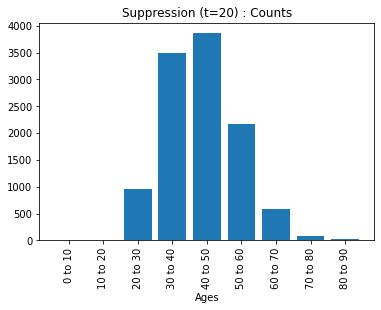

In [167]:
plt.bar(ages,supp_counts_20)
plt.title('Suppression (t=20) : Counts')
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.show()

* Threshold = 40

In [168]:
#Suppression
supp_counts_40=list(map(lambda a: a if a==max([a,40]) else 0, counts))
print(supp_counts_40)

[0, 0, 955, 3487, 3860, 2170, 591, 75, 0]


In [169]:
#Absolute Error
supp_counts_40=np.array(supp_counts_40)
abs_err_supp_40_counts=(counts_np-supp_counts_40).sum()
print(abs_err_supp_40_counts)

23


In [170]:
min_age_sum_supp_40=0
print("For a threshold of 40, the minority age sum is ",min_age_sum_supp_40)
age_sum_supp_40=sum(list(map(lambda a: ((a*10)+5)*supp_counts_40[a], range(len(supp_counts_40)))))
print(age_sum_supp_40)

For a threshold of 40, the minority age sum is  0
483010


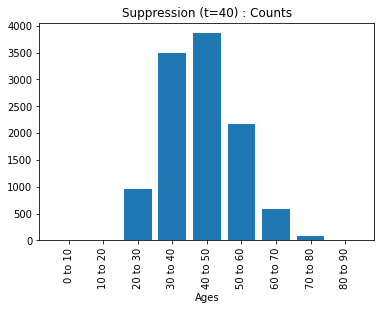

In [171]:
plt.bar(ages,supp_counts_40)
plt.title('Suppression (t=40) : Counts')
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.show()

## Enter the Discrete Laplace/Geometric Mechanism :)

In [172]:
eps=1

In [173]:
import random

In [174]:
#Code Block Credits : Andrew Reed (https://mathoverflow.net/questions/213221/what-is-a-two-sided-geometric-distribution)
def zeroProb(p):
#                    this is the chance of "staying put at 0"
  if random.random()<(1.0 - p)/(1.0 + p):
    return 0
  else:
    return 1
    # Coin flip to determine if the result is negative or positive.
    # This only applies when we "leave 0."
def signProb():
  if random.random() < 0.5:
    return -1
  else:
    return 1

def twoSidedGeoDist(p):
#      (1) Did we "leave 0"? [Y=1|N=0]          (3) +/-
  return zeroProb(p) * np.random.geometric(1-p) * signProb()
def mech_disclaplace(eps,sens=1):
  return twoSidedGeoDist(math.e**(-eps))

In [175]:
dp_counts=[]
for i in range(len(counts)):
  dp_counts.append(counts[i]+twoSidedGeoDist(math.e**(-eps)))
  #dp_counts.append(counts[i]+np.random.laplace(1/eps))
  #dp_counts.append(counts[i]+np.random.geometric(((math.e**eps)-1)/(2*((math.e**2)-1))))

In [176]:
print(dp_counts)

[0, 3, 955, 3487, 3858, 2166, 591, 77, 19]


In [177]:
sum(dp_counts)
#sum(counts)

11156

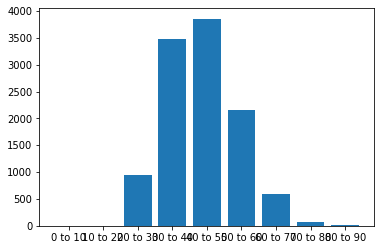

In [178]:
#First run of the Discrete Laplace Mech. Works!
plt.bar(ages,dp_counts)
plt.show()

### Errors. Errors everywhere.
#### DP
1. For $\epsilon=1$.

In [179]:
eps=1
counts_np=np.array(counts)
dp_counts_np=np.array(dp_counts)
err_dp=(counts_np-dp_counts_np).sum()
print(abs(err_dp))

5


#### Looks great. Multiple iterations now.

100 iterations. Focus on the 5-10 worst error values.

Edit: 1000 iterations!

In [180]:
eps=1
error_vec_1=[]
dp_count_vec_1=[]
dp_counts_sum_1=np.zeros(len(counts))
err_worst_dp_1=[[0 for col in range(len(counts))] for row in range(10)]
for i in range(1000):
  dp_counts_1=[]
  for i in range(len(counts)):
    dp_counts_1.append(counts[i]+twoSidedGeoDist(math.e**(-eps)))
  dp_counts_np_1=np.array(dp_counts_1)
  dp_count_vec_1.append(dp_counts_np_1)
  counts_np=np.array(counts)
  err_dp=((counts_np-dp_counts_np_1)).sum()
  error_vec_1.append(err_dp)
  dp_counts_sum_1=dp_counts_sum_1+dp_counts_np_1
dp_avg_counts_1=dp_counts_sum_1/1000

In [181]:
#Absolute error vector
error_vec_1=abs(np.array(error_vec_1))
error_vec_1.sort()
print(error_vec_1)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

In [182]:
#extracting the worst absolute errors (count)
err_worst_dp_1=error_vec_1[-10:]
print(err_worst_dp_1)
print(sum(err_worst_dp_1)/len(err_worst_dp_1))

[11 11 11 12 12 13 13 14 14 17]
12.8


In [183]:
#Least amount of error to make it onto the naughty list; it only makes sense to have all the similarly ill performing histograms included
dp_cutoff_1=abs(min(err_worst_dp_1))
#print(dp_cutoff_1)
dp_worst_vec_1=[]
for i in range(len(dp_count_vec_1)):
    c=abs(sum(dp_count_vec_1[i]-counts_np))
    if (c>=dp_cutoff_1):
        dp_worst_vec_1.append(dp_count_vec_1[i])
#print(len(dp_worst_vec_1))

In [184]:
dp_worst_sums_1=[]
for i in range(len(dp_worst_vec_1)):
  dp_worst_sums_1.append(sum(dp_worst_vec_1[i]*np.arange(5,86,10)))
print(dp_worst_sums_1)

[485150, 484440, 484045, 485200, 485190, 485520, 484290, 483950, 485170, 485255, 485475, 485270, 484390, 484510, 485330, 485240, 484160, 484330, 485485]


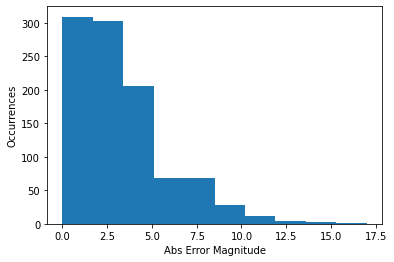

In [185]:
plt.hist(error_vec_1)
plt.xlabel("Abs Error Magnitude")
plt.ylabel("Occurrences")
plt.show()

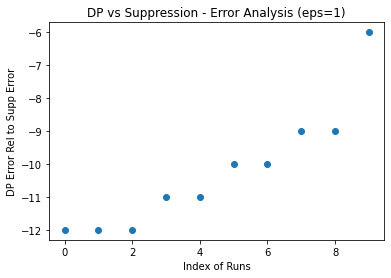

In [186]:
# Vs Suppression
abs_err_supp_arr_1=np.ones(len(err_worst_dp_1))*abs_err_supp_40_counts
plt.scatter(range(len(err_worst_dp_1)),err_worst_dp_1-abs_err_supp_arr_1)
plt.xlabel("Index of Runs")
plt.ylabel("DP Error Rel to Supp Error")
plt.title("DP vs Suppression - Error Analysis (eps=1)")
plt.show()
#DP outperforms this very well

In [187]:
#Age sums
age_sum_dp_1=sum(list(map(lambda a: ((a*10)+5)*dp_avg_counts_1[a], range(len(dp_avg_counts_1)))))
print(age_sum_dp_1)
#Minority Age Sum
min_age_sum_dp_1=15*dp_avg_counts_1[1]+85*dp_avg_counts_1[-1]
print(min_age_sum_dp_1)

484762.70499999996
1753.035


Great. Now for

2. $\epsilon=2$

In [188]:
error_vec_2=[]
eps=2
dp_count_vec_2=[]
dp_counts_sum_2=np.zeros(len(counts))
for i in range(1000):
  dp_counts_2=[]
  for i in range(len(counts)):
    dp_counts_2.append(counts[i]+twoSidedGeoDist(math.e**(-eps)))
  dp_counts_np_2=np.array(dp_counts_2)
  dp_count_vec_2.append(dp_counts_np_2)
  counts_np=np.array(counts)
  err_dp=(counts_np-dp_counts_np_2).sum()
  error_vec_2.append(err_dp)
  dp_counts_sum_2=dp_counts_sum_2+dp_counts_np
dp_avg_counts_2=dp_counts_sum_2/1000

In [189]:
#Absolute error vector
error_vec_2=abs(np.array(error_vec_2))
error_vec_2.sort()
print(error_vec_2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [190]:
#extracting the worst absolute errors
err_worst_dp_2=error_vec_2[-10:]
print(err_worst_dp_2)
print(sum(err_worst_dp_2)/len(err_worst_dp_2))

[5 5 5 6 6 6 6 6 6 6]
5.7


In [191]:
#Least amount of error to make it onto the naughty list; it only makes sense to have all the similarly ill performing histograms included
dp_cutoff_2=abs(min(err_worst_dp_2))
print(dp_cutoff_2)
#print(err_worst_dp_2)
dp_worst_vec_2=[]
for i in range(len(dp_count_vec_2)):
    c=abs(sum((dp_count_vec_2[i]-counts_np)))
    if (c>=dp_cutoff_2):
        dp_worst_vec_2.append(dp_count_vec_2[i])
print(len(dp_worst_vec_2))

5
11


In [192]:
dp_worst_sums_2=[]
for i in range(len(dp_worst_vec_2)):
  dp_worst_sums_2.append(sum(dp_worst_vec_2[i]*np.arange(5,86,10)))
print(dp_worst_sums_2)

[485125, 484655, 484950, 484880, 484530, 484535, 484930, 484855, 485035, 484505, 484385]


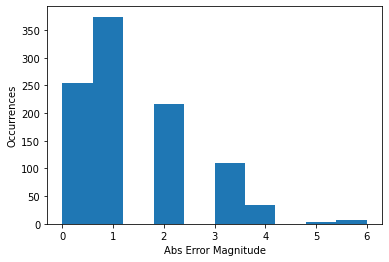

In [193]:
#Visualising empirical error : looks like a discrete Laplace distribution
plt.hist(error_vec_2)
plt.xlabel("Abs Error Magnitude")
plt.ylabel("Occurrences")
plt.show()

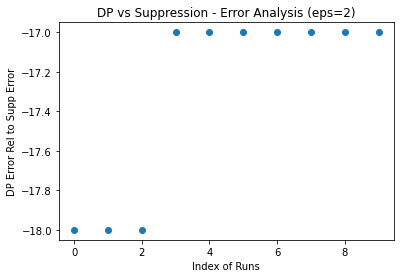

In [194]:
# Vs Suppression
abs_err_supp_arr_2=np.ones(len(err_worst_dp_2))*abs_err_supp_40_counts
plt.scatter(range(len(err_worst_dp_2)),err_worst_dp_2-abs_err_supp_arr_2)
plt.xlabel("Index of Runs")
plt.ylabel("DP Error Rel to Supp Error")
plt.title("DP vs Suppression - Error Analysis (eps=2)")
plt.show()

In [195]:
#Age sums
age_sum_dp_2=sum(list(map(lambda a: ((a*10)+5)*dp_avg_counts_2[a], range(len(dp_counts_2)))))
print(age_sum_dp_2)
#Minority Age Sum
min_age_sum_dp_2=15*dp_avg_counts_2[1]+85*dp_avg_counts_2[-1]
print(min_age_sum_dp_2)

484510.0
1660.0


So far so good, everything is going as expected. Now for

3. $\epsilon=5$

In [196]:
error_vec_5=[]
dp_counts_sum_5=np.zeros(len(counts))
eps=5
dp_count_vec_5=[]
for i in range(1000):
  dp_counts_5=[]
  for i in range(len(counts)):
    dp_counts_5.append(counts[i]+twoSidedGeoDist(math.e**(-eps)))
  dp_counts_np_5=np.array(dp_counts_5)
  dp_count_vec_5.append(dp_counts_np_5)
  counts_np=np.array(counts)
  err_dp=(counts_np-dp_counts_np_5).sum()
  error_vec_5.append(err_dp)
  dp_counts_sum_5=dp_counts_sum_5+dp_counts_np_5
dp_avg_counts_5=dp_counts_sum_5/1000

In [197]:
#Absolute error vector
error_vec_5=abs(np.array(error_vec_5))
error_vec_5.sort()
print(error_vec_5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [198]:
#extracting the worst absolute errors
err_worst_dp_5=error_vec_5[-10:]
print(err_worst_dp_5)
print(sum(err_worst_dp_5)/len(err_worst_dp_5))

[1 1 1 1 1 1 1 2 2 2]
1.3


In [199]:
#Least amount of error to make it onto the naughty list; it only makes sense to have all the similarly ill performing histograms included
dp_cutoff_5=abs(min(err_worst_dp_5))
print(dp_cutoff_5)
#print(err_worst_dp_5)
dp_worst_vec_5=[]
for i in range(len(dp_count_vec_5)):
    c=abs(sum((dp_count_vec_5[i]-counts_np)))
    if (c>=dp_cutoff_5):
        dp_worst_vec_5.append(dp_count_vec_5[i])
print(len(dp_worst_vec_5))

1
103


In [200]:
dp_worst_sums_5=[]
for i in range(len(dp_worst_vec_5)):
  dp_worst_sums_5.append(sum(dp_worst_vec_5[i]*np.arange(5,86,10)))
print(dp_worst_sums_5)

[484820, 484730, 484770, 484820, 484820, 484710, 484770, 484770, 484680, 484790, 484680, 484740, 484820, 484680, 484750, 484690, 484720, 484750, 484720, 484700, 484730, 484690, 484670, 484670, 484760, 484840, 484810, 484730, 484810, 484700, 484790, 484780, 484740, 484760, 484730, 484670, 484690, 484820, 484700, 484810, 484720, 484760, 484770, 484680, 484670, 484820, 484720, 484680, 484740, 484690, 484760, 484830, 484915, 484820, 484780, 484840, 484690, 484700, 484840, 484740, 484740, 484800, 484730, 484820, 484840, 484720, 484800, 484820, 484740, 484680, 484700, 484780, 484830, 484770, 484820, 484750, 484840, 484820, 484720, 484645, 484790, 484790, 484690, 484680, 484830, 484810, 484820, 484790, 484820, 484810, 484700, 484710, 484690, 484770, 484715, 484780, 484830, 484750, 484720, 484740, 484670, 484820, 484770]


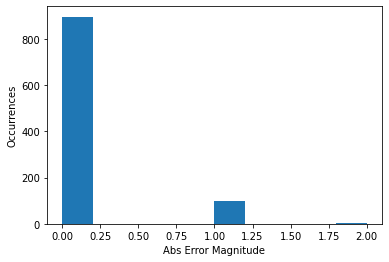

In [201]:
#Visualising empirical error : looks like a discrete Laplace distribution
plt.hist(error_vec_5)
plt.xlabel("Abs Error Magnitude")
plt.ylabel("Occurrences")
plt.show()

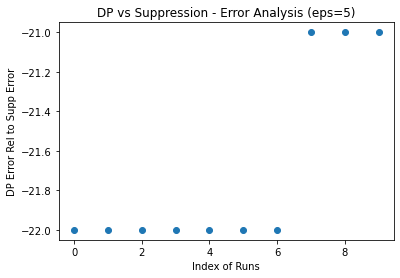

In [202]:
# DP (eps=5) Vs Suppression
abs_err_supp_arr_5=np.ones(len(err_worst_dp_5))*abs_err_supp_40_counts
plt.scatter(range(len(err_worst_dp_5)),err_worst_dp_5-abs_err_supp_arr_5)
plt.xlabel("Index of Runs")
plt.ylabel("DP Error Rel to Supp Error")
plt.title("DP vs Suppression - Error Analysis (eps=5)")
plt.show()

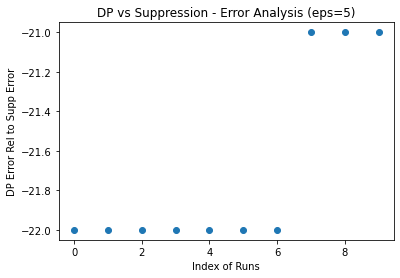

In [203]:
# DP (eps=5) vs Anon (k=20)
abs_err_supp_arr_5=np.ones(len(err_worst_dp_5))*abs_err_supp_40_counts
plt.scatter(range(len(err_worst_dp_5)),err_worst_dp_5-abs_err_supp_arr_5)
plt.xlabel("Index of Runs")
plt.ylabel("DP Error Rel to Supp Error")
plt.title("DP vs Suppression - Error Analysis (eps=5)")
plt.show()

In [204]:
#Age sums
age_sum_dp_5=sum(list(map(lambda a: ((a*10)+5)*dp_counts_5[a], range(len(dp_counts_5)))))
print(age_sum_dp_5)
#Minority Age Sum
min_age_sum_dp_5=15*dp_avg_counts_5[1]+85*dp_avg_counts_5[-1]
print(min_age_sum_dp_5)

484755
1744.985


## Error Comparisons for Age Sums

In [205]:
#Suppression errors
supp_sum_err_20=age_sum_supp_20-sum(est_bin_age_sum)
supp_sum_err_40=age_sum_supp_40-sum(est_bin_age_sum)
print(abs(supp_sum_err_40),abs(supp_sum_err_20))

1745 45


In [206]:
#Anonymisation error
anon_sum_err_40=sum(anon_age_sum_40)-sum(est_bin_age_sum)
anon_sum_err_20=sum(anon_age_sum_20)-sum(est_bin_age_sum)
print(abs(anon_sum_err_40),abs(anon_sum_err_20))

4485 4760


In [207]:
#DP Errors
#For eps=1
dp_errs_1=[]
for i in range(len(dp_worst_sums_1)):
  dp_errs_1.append(abs(dp_worst_sums_1[i]-sum(est_bin_age_sum)))
print(dp_errs_1)

[395, 315, 710, 445, 435, 765, 465, 805, 415, 500, 720, 515, 365, 245, 575, 485, 595, 425, 730]


In [208]:
#For eps=2
dp_errs_2=[]
for i in range(len(dp_worst_sums_2)):
  dp_errs_2.append(abs(dp_worst_sums_2[i]-sum(est_bin_age_sum)))
print(dp_errs_2)
#For eps=5
dp_errs_5=[]
for i in range(len(dp_worst_sums_5)):
  dp_errs_5.append(abs(dp_worst_sums_5[i]-sum(est_bin_age_sum)))
print(dp_errs_5)

[370, 100, 195, 125, 225, 220, 175, 100, 280, 250, 370]
[65, 25, 15, 65, 65, 45, 15, 15, 75, 35, 75, 15, 65, 75, 5, 65, 35, 5, 35, 55, 25, 65, 85, 85, 5, 85, 55, 25, 55, 55, 35, 25, 15, 5, 25, 85, 65, 65, 55, 55, 35, 5, 15, 75, 85, 65, 35, 75, 15, 65, 5, 75, 160, 65, 25, 85, 65, 55, 85, 15, 15, 45, 25, 65, 85, 35, 45, 65, 15, 75, 55, 25, 75, 15, 65, 5, 85, 65, 35, 110, 35, 35, 65, 75, 75, 55, 65, 35, 65, 55, 55, 45, 65, 15, 40, 25, 75, 5, 35, 15, 85, 65, 15]


### Just to be nice: graphical representations of sum errors

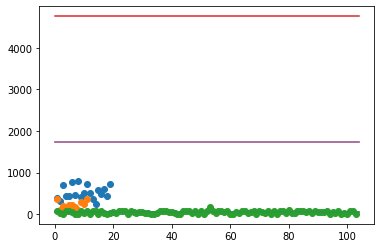

In [209]:
plt.scatter(np.arange(1,len(dp_errs_1)+1),dp_errs_1)
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_40)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(anon_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_40)*np.ones(2))
plt.scatter(np.arange(1,len(dp_errs_2)+1),dp_errs_2)
plt.scatter(np.arange(1,len(dp_errs_5)+1),dp_errs_5)

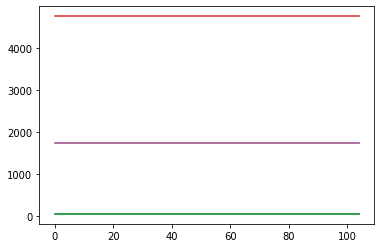

In [210]:
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_40)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(anon_sum_err_20)*np.ones(2))
plt.plot([0,max(len(dp_errs_1)+1,len(dp_errs_2)+1,len(dp_errs_5)+1)],abs(supp_sum_err_40)*np.ones(2))

## No. of times DP gets beaten (age sum)
DP beats everything completely except for suppression with $k=20$ 

In [211]:
agesum_supp_20_v_DP_1=[a for a in dp_errs_1 if a>abs(supp_sum_err_20)]
print(len(agesum_supp_20_v_DP_1))
print(len(dp_errs_1))

19
19


In [212]:
agesum_supp_40_v_DP_1=[a for a in dp_errs_1 if a>abs(supp_sum_err_40)]
print(len(agesum_supp_40_v_DP_1))
print(len(dp_errs_1))

0
19


In [213]:
agesum_supp_20_v_DP_2=[a for a in dp_errs_2 if a>abs(supp_sum_err_20)]
print(len(agesum_supp_20_v_DP_2))
print(len(dp_errs_2))

11
11


In [214]:
agesum_supp_40_v_DP_2=[a for a in dp_errs_2 if a>abs(supp_sum_err_40)]
print(len(agesum_supp_40_v_DP_2))
print(len(dp_errs_2))

0
11


In [215]:
agesum_supp_20_v_DP_5=[a for a in dp_errs_5 if a>abs(supp_sum_err_20)]
print(len(agesum_supp_20_v_DP_5))
print(len(dp_errs_5))

55
103


In [216]:
agesum_supp_40_v_DP_5=[a for a in dp_errs_5 if a>abs(supp_sum_err_40)]
print(len(agesum_supp_40_v_DP_5))
print(len(dp_errs_5))

0
103
